# K-Means Clustering Implementation

**K-Means Clustering** is an unsupervised machine learning algorithm that groups data points into k clusters based on their similiarity using Euclidean distance.

## Step 1: Importing Libraries

- **NumPy**: for numerical operations (such as Euclidiean distance)
- **MatplotLib**: for plotting data and results

In [83]:
import numpy as np
import matplotlib.pyplot as plt

## Step 2: Loading data from data.txt

Each line contains two spaced-seperated floating-point values (x,y coordinates) which is a 2 feature data set

In [84]:
#Function to load data from data.txt file

def load_data(filename):
    """
    Load 2D data points from a text file.
    Each line should contain two space-separated floating-point values.
    """
    data = []
    with open(filename, 'r') as f:
        for line in f:
            #strip() removes whitespace from the beginning and end of the line
            #split() splits the line into a list of strings based on whitespace between the values
            parts = line.strip().split()
            if len(parts) >= 2: #only evaluate lines with at least 2 values
                x, y = float(parts[0]), float(parts[1]) #convert the string values to floats
                data.append([x, y]) #append the float values as a list to the data list
    return np.array(data) #convert the list of lists to a numpy array

#Load the data
X = load_data('data.txt')
print(f"Loaded {X.shape[0]} data points with {X.shape[1]} features")
print(f'Data shape: {X.shape}')
print(f'\nFirst 5 data points:')
print(X[:5]) #matches the first 5 data points in the data.txt file
    

Loaded 5000 data points with 2 features
Data shape: (5000, 2)

First 5 data points:
[[ 0.009519 -0.636513]
 [ 0.977144 -0.823159]
 [-0.001936  0.65852 ]
 [ 0.626724 -0.770501]
 [-0.694547 -0.028682]]


## Step 3: Plotting the Raw Dataset

Visualizing the dataset to understand the distribution of the data

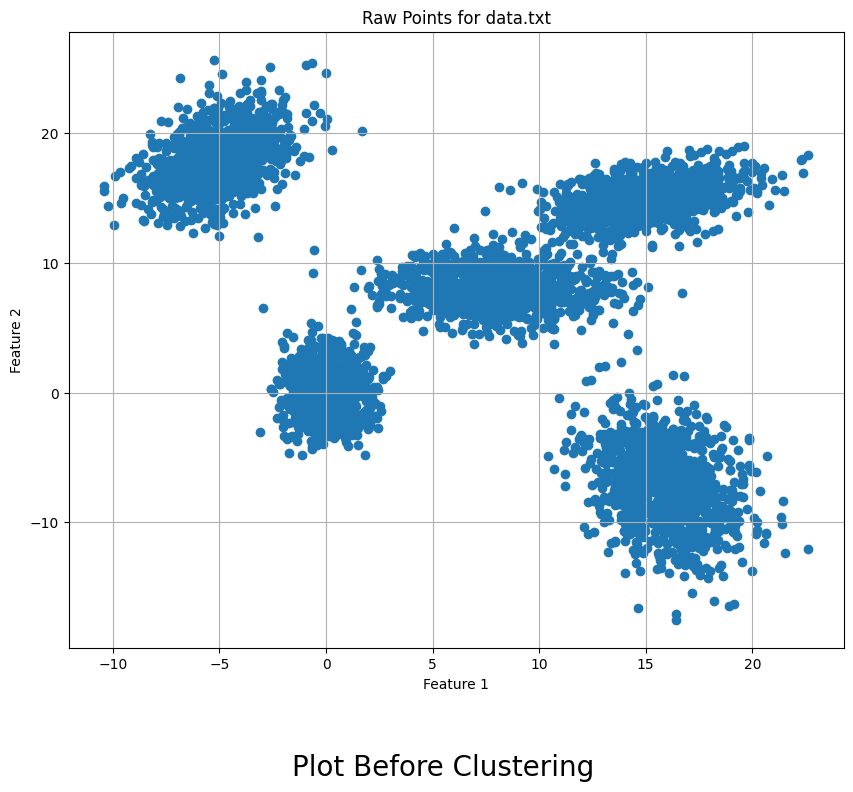

In [85]:
fig = plt.figure(figsize=(10,8)) #create a figure with a size of 10x8 inches
plt.grid(True) #add a grid to the plot
plt.scatter(X[:,0], X[:,1]) #plot the data points with a transparency of 0.6 and a size of 20
plt.title("Raw Points for data.txt")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.figtext(0.5, -0.05, "Plot Before Clustering", ha="center", fontsize=20)
plt.show()



## Step 4: Initialize Random Centroids

Randomly initialize k centroids for K-Means clsutering. The number of clusters 'k' represents how many groups we want to classify our items into. 

Based off of the scatter plot, there appears to be four clusterings, so let's start with k=4.

In [86]:
k = 5

clusters = {}
np.random.seed(42) #set the random seed for reproducibility

#Find the range of data for each feature and generate random centroids within that range
min_x, max_x = X[:, 0].min(), X[:, 0].max()
min_y, max_y = X[:, 1].min(), X[:, 1].max()

print(f'Min X: {min_x:.4f}, Max X: {max_x:.4f}')
print(f'Min Y: {min_y:.4f}, Max Y: {max_y:.4f}')

for idx in range(k):
    center = np.array([
        np.random.uniform(min_x, max_x),
        np.random.uniform(min_y, max_y)
    ])
    points = []
    cluster = {
        'center': center,
        'points': []
    }
    clusters[idx] = cluster

#Display the initialized clusters
print("Initialized centroids:")
for i in clusters:
    center = clusters[i]['center']
    print(f"Cluster {i}: center = ({center[0]:.4f}, {center[1]:.4f})")


print(clusters)

Min X: -10.4264, Max X: 22.6264
Min Y: -17.5198, Max Y: 25.6401
Initialized centroids:
Cluster 0: center = (1.9532, 23.5129)
Cluster 1: center = (13.7681, 8.3182)
Cluster 2: center = (-5.2695, -10.7871)
Cluster 3: center = (-8.5066, 19.8642)
Cluster 4: center = (9.4421, 13.0405)
{0: {'center': array([ 1.95320702, 23.51290289]), 'points': []}, 1: {'center': array([13.76805424,  8.31821233]), 'points': []}, 2: {'center': array([ -5.26953817, -10.78711566]), 'points': []}, 3: {'center': array([-8.50656439, 19.86424517]), 'points': []}, 4: {'center': array([ 9.44214005, 13.04051257]), 'points': []}}


## Step 5: Plotting Random Initialized Centers with Data Points


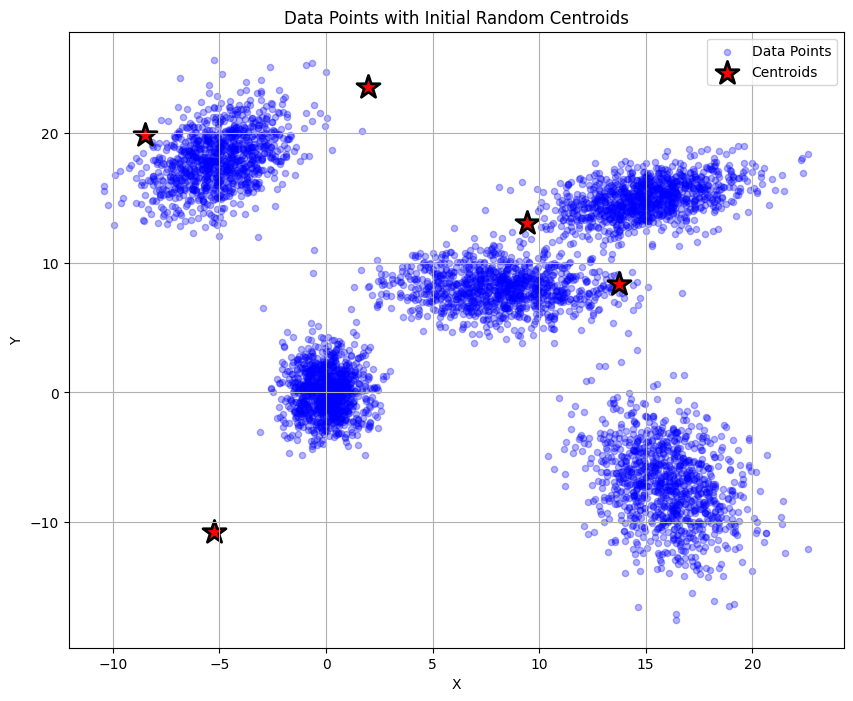

In [87]:
plt.figure(figsize=(10,8))
plt.scatter(X[:,0], X[:,1], alpha=0.3, s=20, c='blue', label='Data Points')
plt.grid(True)
for i in clusters:
    center = clusters[i]['center'] #extract X,Y coordinates of the center
    plt.scatter(center[0], center[1], marker='*', c='red', s=300, edgecolors='black', linewidths=2, label='Centroids' if i == 0 else '')
plt.title('Data Points with Initial Random Centroids')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()



## Step 6: Defining Euclidean Distance

**Euclidean Distance formula**: √((x₁-x₂)² + (y₁-y₂)²)

In [88]:
def distance(p1, p2):
    """
    Calculate Euclidean distance between two points.
    p1 and p2 are numpy arrays representing points.
    """
    return np.sqrt(np.sum((p1-p2)**2))

#Test the distance function
test_p1 = np.array([0,0])
test_p2 = np.array([3,4])
print(f"Distance between (0,0) and (3,4): {distance(test_p1, test_p2):.2f}")


Distance between (0,0) and (3,4): 5.00


## Step 7: Creating Assign and Update Functions

We need two key functions
1. **assign_clusters**: Assigns each data point to the nearest centroid
2. **update_clusters**: Recalcuates the centroids based on the average of points that are assigned to each cluster.

The clusters created in the previous cell will be leveraged. The points will be assigned to each centroid, and then the average of all those points will be obtained, which will then be used to reassign the value of the centroid at that index.

In [89]:
def assign_clusters(X, clusters, k):
    """
    Assign each data point to the nearest centroid.
    """
    #iterate through each point in the dataset
    for idx in range(X.shape[0]):
        dist = [] #empty list to store distances matching their index
        current_x = X[idx] #current point
        
        #Calculate the distance between the current point and each centroid
        for i in range(k):
            dis = distance(current_x, clusters[i]['center'])
            dist.append(dis)
        
        curr_cluster = np.argmin(dist) #Find the index of the closest cluster, so it can be assisnged to that cluster
        clusters[curr_cluster]['points'].append(current_x)
        
    return clusters

def update_clusters(X, clusters, k):
    """
    Recalculate the centroids based on the assigned points.
    """
    for i in range(k):
        points = np.array(clusters[i]['points'])
        if points.shape[0] > 0: #ensure there are points assigned to the cluster
            new_center = points.mean(axis=0) #must add axis = 0 to get the mean along the rows (giving mean along each column)
            clusters[i]['center'] = new_center
            clusters[i]['points'] = [] #clear points for next iteration
    return clusters



##Step 8: Running the K-Means Algorithm

Continue K-means algorithm iteratively

1. Assign points to nearest centroids
2. Update centroids basedo n assigned points
3. Repeat until convergence occurs

In [90]:
#Reset clusters for the algorithm for better visualization
clusters = {}
np.random.seed(23)
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()


for idx in range(k):
    center = np.array([
        np.random.uniform(x_min, x_max),
        np.random.uniform(y_min, y_max)
    ])
    clusters[idx] = {
        'center': center,
        'points': []
    }

#Run K-Means algorithm
max_iters = 100
tolerance = 1e-4
prev_centers = None
max_change = float('inf') #Initialize max_change

for iteration in range(max_iters):
    #Assign points to nearest centroids
    clusters = assign_clusters(X, clusters, k)
    
    #Update centroids based on assigned points
    clusters = update_clusters(X, clusters, k)
    
    #Check for convergence
    if prev_centers is not None:
        max_change = 0
        for i in range(k):
            change = distance(clusters[i]['center'], prev_centers[i])
            max_change = max(max_change, change)
            
        if max_change < tolerance:
            print(f"Converged after {iteration + 1} iterations")
            break
            
    #Store current centers for next iteration
    prev_centers = [clusters[i]['center'].copy() for i in range(k)]
    
    if prev_centers is not None and (iteration + 1) % 10 == 0:
        print(f"Iteration {iteration + 1}: Max centroid change = {max_change:.6f}")

print(f"\nAlgorithm completed in {iteration + 1} iterations")



Converged after 4 iterations

Algorithm completed in 4 iterations


## Step 9: Predicting the cluster for the Data Points

Create a function to predict the cluster assignment for each data point based on the final centroids

In [91]:
def pred_cluster(X, clusters, k):
    """
    Predict cluster assignment for each data point.
    """
    #pred contains the index of the closest cluster for each point
    #This maps each point to the index of the closest centroid
    pred = []
    for i in range(X.shape[0]):
        dist = []
        for j in range(k):
            dist.append(distance(X[i], clusters[j]['center']))
        pred.append(np.argmin(dist))  # Append index of closest cluster
    return pred

# Predict clusters for all data points
pred = pred_cluster(X, clusters, k)

# Display some predictions
print("First 10 predictions:")
print(f'Prediction 1: Centroid {pred[0]} contains point: {X[0]}')
print(f'{pred[:10]}')
print(f"\nTotal predictions: {len(pred)}")


First 10 predictions:
Prediction 1: Centroid 3 contains point: [ 0.009519 -0.636513]
[np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3), np.int64(3)]

Total predictions: 5000


## Step 10: Plotting Data Points with Predicted Cluster Centers

Finally, let's visualize the data points colored by their predicted clusters, along with the final centroids (marked with red triangles).


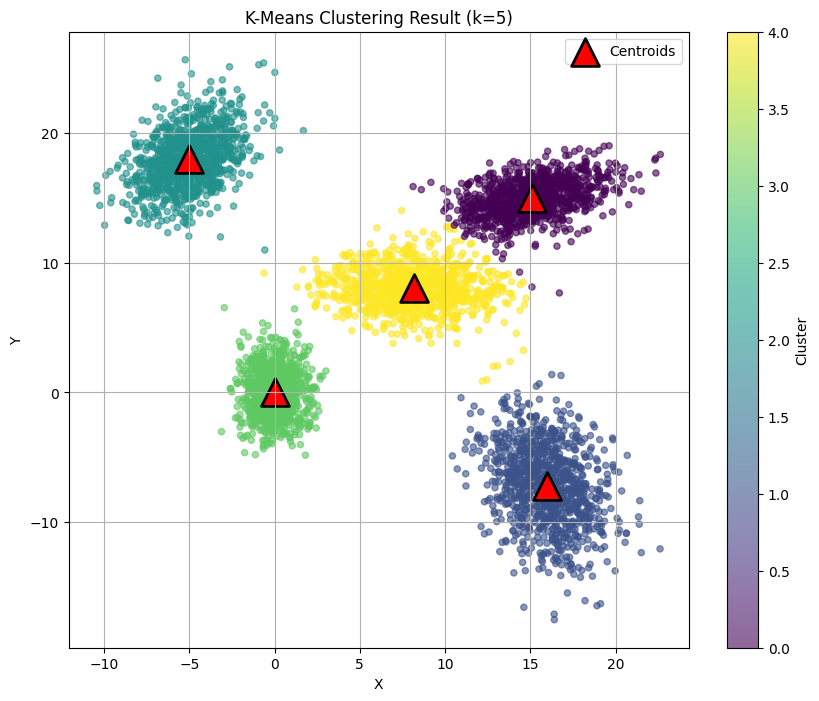

In [ ]:
plt.figure(figsize=(10, 8))
plt.grid(True)

# Plot data points colored by cluster
#c=pred is the color of the points, mapped to the predicted cluster in step 9
scatter = plt.scatter(X[:, 0], X[:, 1], c=pred, cmap='viridis', 
                     alpha=0.6, s=20)

# Plot centroids
for i in clusters:
    center = clusters[i]['center']
    plt.scatter(center[0], center[1], marker='^', c='red', s=400,
               edgecolors='black', linewidths=2, label='Centroids' if i == 0 else '')

plt.colorbar(scatter, label='Cluster')
plt.title(f'K-Means Clustering Result (k={k})')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()
